In [381]:
import numpy as np
from scipy.constants import e, m_p, m_e, c, epsilon_0, m_n, k as kb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from cycler import cycler
import glob, os
from astropy.io import fits
from scipy.ndimage import label, center_of_mass
from matplotlib.patches import Circle
from tools import *

plt.rcParams.update({
    # Color cycle
    "axes.prop_cycle": cycler('color', ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']),

    # Figure size
    "figure.figsize": (4, 3),

    # X ticks
    "xtick.direction": "in",
    "xtick.major.size": 3,
    "xtick.major.width": 0.5,
    "xtick.minor.size": 1.5,
    "xtick.minor.width": 0.5,
    "xtick.minor.visible": True,
    "xtick.top": True,

    # Y ticks
    "ytick.direction": "in",
    "ytick.major.size": 3,
    "ytick.major.width": 0.5,
    "ytick.minor.size": 1.5,
    "ytick.minor.width": 0.5,
    "ytick.minor.visible": True,
    "ytick.right": True,

    # Axes & lines
    "axes.linewidth": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 1.0,

    # Font & math
    "font.family": "sans-serif",
    #"mathtext.fontset": "dejavuserif",
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",

    # Legend & saving
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05
})


In [14]:
%matplotlib widget

In [4]:
%matplotlib inline

# Preliminary

## Plot the original image 

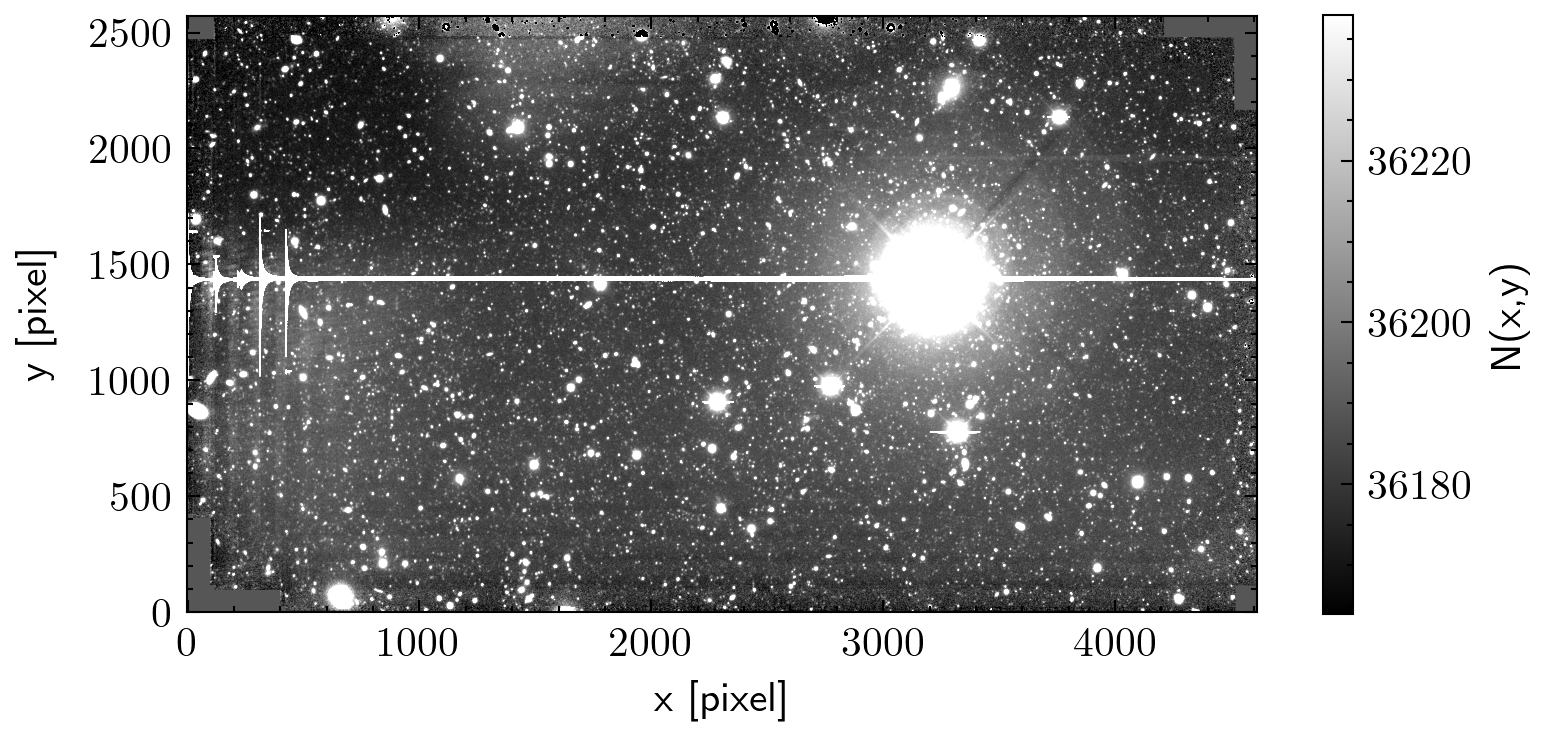

In [5]:
# Load the FITS file
with fits.open("data/Fits_Data/mosaic.fits") as hdul:
    image_data = hdul[0].data # this contains the count in each pixel
    header = hdul[0].header

# Apply scaling
# REAL = TAPE*BSCALE + BZERO                     
scaled_image = image_data.T * header.get('BSCALE', 1) + header.get('BZERO', 0)

# Get aspect ratio (width / height)
ny, nx = scaled_image.shape
aspect_ratio = nx / ny
enlarge = 1

# Plot
plt.figure(figsize=(3 * aspect_ratio * enlarge, 3 * enlarge), dpi=300)
plt.imshow(
    scaled_image,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(scaled_image, 5),
    vmax=np.percentile(scaled_image, 95)
)
plt.title('')
plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()

## Plot histogram for the original image (zoom into the Gaussian region)

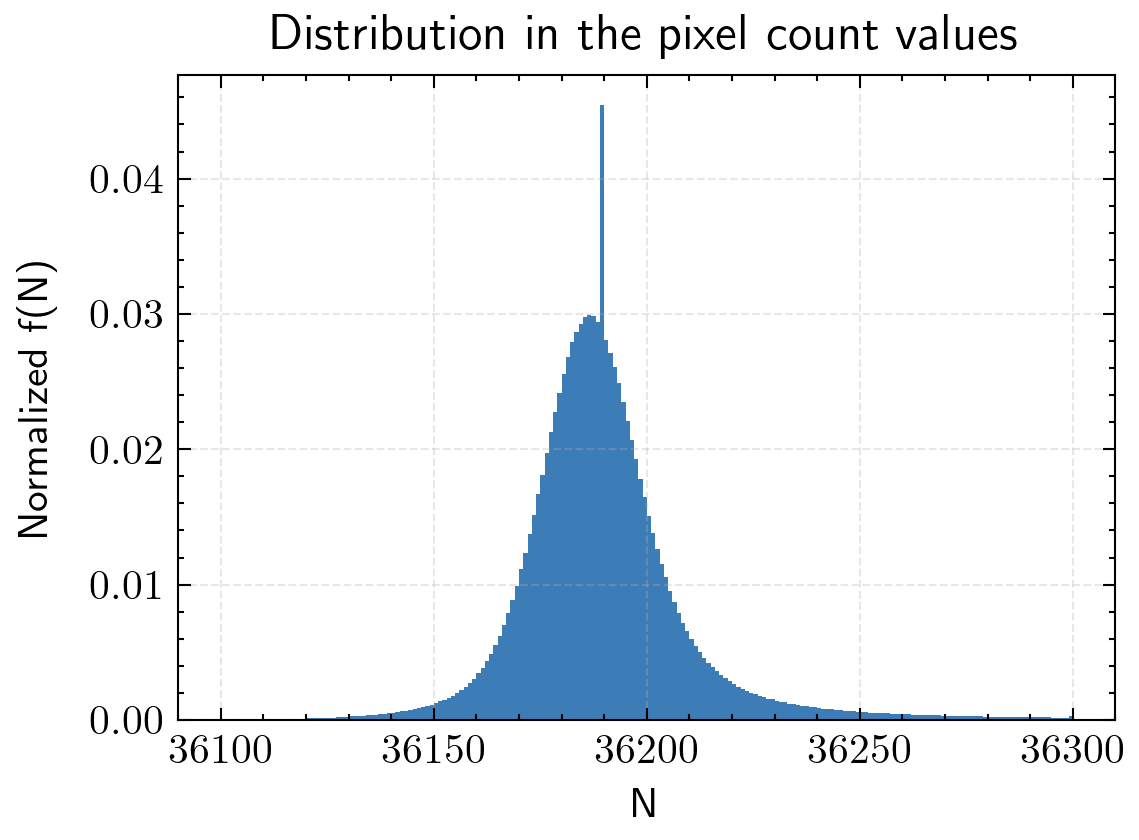

Mean: 36189.056
Std:  19.263


In [6]:
# Flatten to 1D array of counts
pixels = scaled_image.flatten()

# Define range
min_count, max_count = 36.1e3, 36.3e3

# Mask pixels within range
mask = (pixels >= min_count) & (pixels <= max_count)
pixels_in_range = pixels[mask]

# Compute mean and std within range
mean_val = np.mean(pixels_in_range)
std_val = np.std(pixels_in_range)

# Compute bins with width = 1
bin_edges = np.arange(min_count, max_count + 1, 1)

# Plot histogram
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(pixels_in_range, bins=bin_edges, alpha=0.8, density=True)
plt.xlabel('N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Distribution in the pixel count values')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Mean: {mean_val:.3f}")
print(f"Std:  {std_val:.3f}")

# De-noising / cleaning

## Crop out the noisy part

Fraction of lost data: 0.1734871863679055


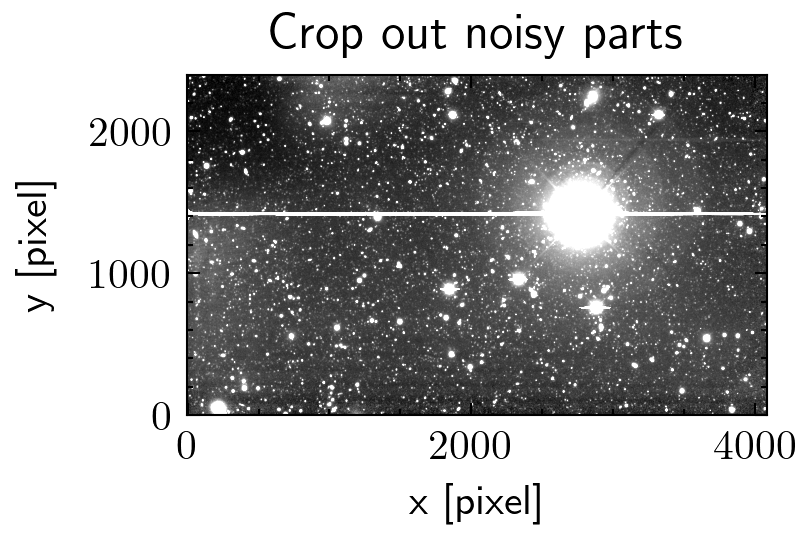

In [7]:
# Crop out the border part
crop = scaled_image[20:-150, 440:-90]
aspect_ratio_new = crop.shape[1] / crop.shape[0]

# Calculate percentage of data lost
print('Fraction of lost data:', 1 - crop.size / scaled_image.size)

# Plot again
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)
plt.imshow(
    crop,
    cmap='gray',
    origin='lower',
    vmin=np.percentile(crop, 5),
    vmax=np.percentile(crop, 95)
)

plt.title('Crop out noisy parts')
# plt.colorbar(label='N(x,y)', shrink=0.78)
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


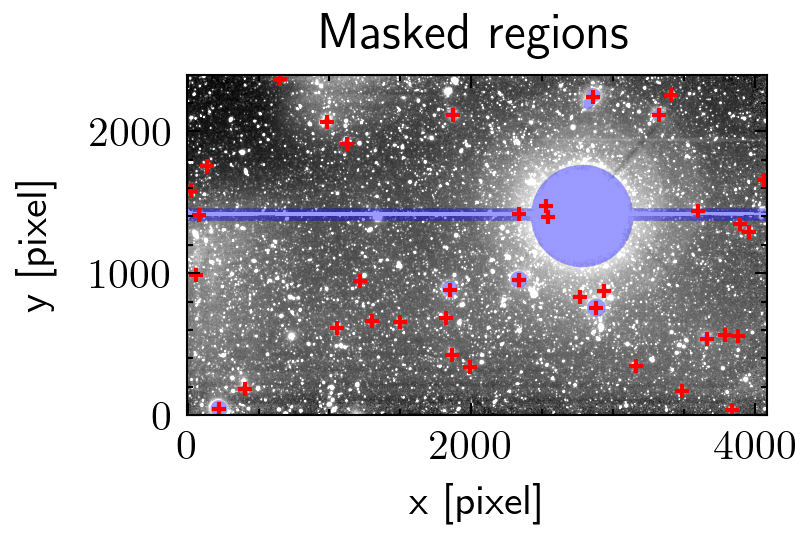

In [9]:
# --- Initialize mask array ---
mask_bool = np.ones_like(crop, dtype=bool)

# --- Apply manual masking ---
mask_bool[1366:1455, :] = False
mask_bool = mask_circle(mask_bool, center=(2780, 1400), radius=360)
mask_bool = mask_circle(mask_bool, center=(2880, 755), radius=65)
mask_bool = mask_circle(mask_bool, center=(1850, 890), radius=55)
mask_bool = mask_circle(mask_bool, center=(2335, 953), radius=60)
mask_bool = mask_circle(mask_bool, center=(3318, 2112), radius=42)
mask_bool = mask_circle(mask_bool, center=(3658, 538), radius=35)
mask_bool = mask_circle(mask_bool, center=(225, 44), radius=60)
mask_bool = mask_circle(mask_bool, center=(2860, 2250), radius=50)
mask_bool = mask_circle(mask_bool, center=(2820, 2180), radius=30)
mask_bool = mask_circle(mask_bool, center=(2820, 2200), radius=30)
mask_bool = mask_circle(mask_bool, center=(2840, 2200), radius=30)
mask_bool = mask_circle(mask_bool, center=(1870, 2110), radius=34)

# --- Detect remaining bright regions ---
bright_mask = crop > 5e4
labels, num = snd.label(bright_mask, structure=np.ones((3, 3)))
centers = snd.center_of_mass(crop, labels, np.arange(1, num + 1))
yy = [c[0] for c in centers]
xx = [c[1] for c in centers]

# --- Mask out small circular regions around detected centers ---
for x, y in zip(xx, yy):
    mask_bool = mask_circle(mask_bool, center=(x, y), radius=24)

# --- Visualize masked regions ---
plt.figure(figsize=(2 * aspect_ratio_new, 2), dpi=300)

# Base grayscale image
plt.imshow(crop, cmap='gray', origin='lower',
           vmin=np.percentile(crop[mask_bool], 5),
           vmax=np.percentile(crop[mask_bool], 95))


# Overlay blue for masked (False) areas
overlay = np.zeros((*mask_bool.shape, 4))  # RGBA
overlay[~mask_bool] = [0, 0, 1, 0.4]       # blue with alpha=0.4
plt.imshow(overlay, origin='lower')


plt.scatter(xx, yy, s=10, marker='+', c='red', linewidths=1)
plt.title('Masked regions')
plt.xlabel('x [pixel]')
plt.ylabel('y [pixel]', labelpad=8)
plt.tight_layout()
plt.show()


## Replot histogram

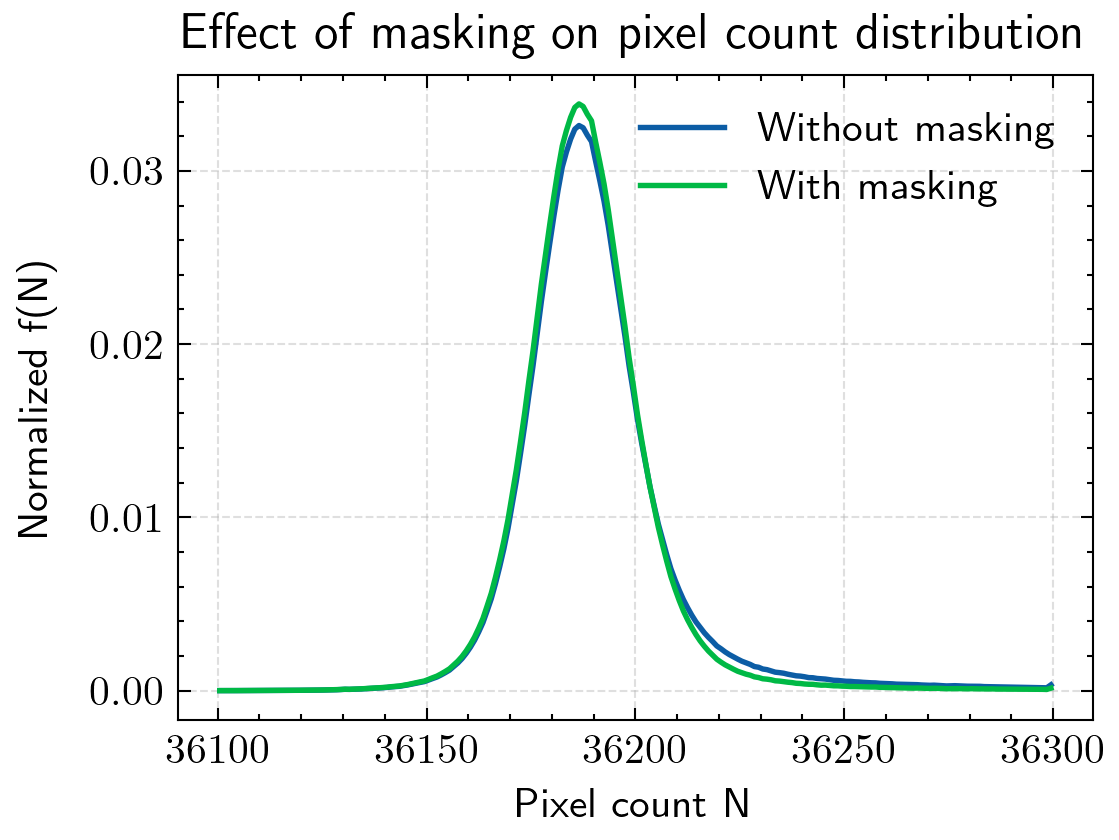

In [10]:
# --- Flatten both arrays ---
pixels_all = crop.flatten()
pixels_masked = crop[mask_bool].flatten()

# --- Define range and bins ---
min_count, max_count = 36.1e3, 36.3e3
bin_edges = np.arange(min_count, max_count + 1, 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Apply range selection ---
pixels_all_in_range = pixels_all[(pixels_all >= min_count) & (pixels_all <= max_count)]
pixels_masked_in_range = pixels_masked[(pixels_masked >= min_count) & (pixels_masked <= max_count)]

# --- Manual histogram (normalized) ---
hist_all, _ = np.histogram(pixels_all_in_range, bins=bin_edges, density=True)
hist_masked, _ = np.histogram(pixels_masked_in_range, bins=bin_edges, density=True)

# --- Plot as smooth line ---
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(bin_centers, hist_all, lw=1.3, label='Without masking')
plt.plot(bin_centers, hist_masked, lw=1.3, label='With masking')
plt.xlabel('Pixel count N')
plt.ylabel('Normalized f(N)', labelpad=8)
plt.title('Effect of masking on pixel count distribution')
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

# Object detection

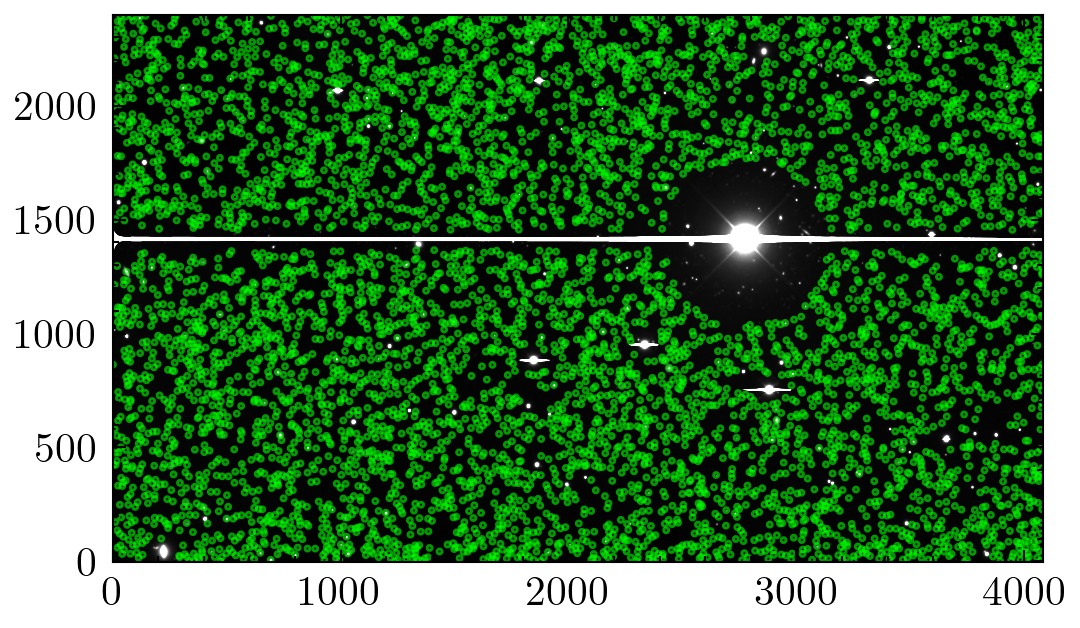

 xcenter    ycenter   true_count
--------- ----------- ----------
337.28747   1.9770386  774.12949
472.57401  0.40121172  611.68224
3894.6091  0.12222841   280.0998
   1877.1   1.6328098  10173.898
1240.1334   2.0729556 -297.76668
2299.4514   2.1090293  1269.5122
2370.4898   1.6475745  1275.9047
4070.0591   2.6665702  500.03177
355.82987   2.6682838  538.31804
1356.8412   3.0941581  1652.2475
994.57326   4.7842859  2106.3072
2761.8517   5.1057232   12031.46
  3251.82   5.4217866  1321.1318
 3738.567 0.019576921  407.54239
929.03793   6.2254148  6947.6642
 3601.716   5.8231344  1502.0875
693.18328   6.8197437  140156.01
1848.3445   5.9893804  1160.5967
3467.4725   8.3888542  113.20978
3942.4012   3.2400428 -20.601597
3982.9647   7.1936196   303.6229
1340.7863   6.8905234  527.85504
2414.5416   10.745862  511.90337
2977.5327   9.0904649  549.82614
 3068.887    7.311754  634.39422
3748.4084   8.9197706  12.488622
      ...         ...        ...
33.435928    2393.768  1527.6008
485.49366 

In [303]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

r_aperture = 6  # pixels

# --- image and mask ---
# test
#img = crop[0:150, 0:150]
#mask = mask_bool[0:150, 0:150]
# full
img = crop
mask = mask_bool

# --- background stats ---
mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=~mask)

# --- detect stellar objects ---
daofind = DAOStarFinder(fwhm=2*r_aperture, threshold=4*std)
sources = daofind(img - median, mask=~mask)

if sources is None or len(sources) == 0:
    print("No sources found.")
else:
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=r_aperture)
    annuli = CircularAnnulus(positions, r_in=1.5 * r_aperture, r_out=2 * r_aperture)

    # --- background measurement ---
    aperstats = ApertureStats(img, annuli, mask=~mask)
    bkg_mean = aperstats.mean  # mean background per pixel
    aperture_area = apertures.area_overlap(img, mask=~mask) # only considering the valid pixels
    total_bkg = bkg_mean * aperture_area # total background

    # --- aperture photometry ---
    phot_table = aperture_photometry(img, apertures, mask=~mask)
    phot_table['total_bkg'] = total_bkg
    phot_table['true_count'] = phot_table['aperture_sum'] - phot_table['total_bkg']

    # --- plot ---
    plt.figure(figsize=(4, 4), dpi=300)
    plt.imshow(img, cmap='gray', origin='lower',
               vmin=np.percentile(img, 5), vmax=np.percentile(img, 99))
    apertures.plot(color='lime', lw=1.2, alpha=0.6)
    plt.show()

    # --- results ---
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'

    print(phot_table['xcenter', 'ycenter', 'true_count'])

# Calibrate flux

In [371]:
count = phot_table['true_count']
exp_time = header['EXPTIME'] # exposure time in second
calibration = header['MAGZPT']
calibration_err = header['MAGZRR']
intru_zero = header['MAGZPT']
m = intru_zero -2.5*np.log10(count/exp_time) 
sigma_m = np.sqrt( (2.5 / np.log(10) * np.sqrt(count) / count)**2 + calibration_err**2 )
# unc comes from sqrt(count) and the unc in calibration err 

/var/folders/hg/0kdv7y6569v6ky7qntrm11l40000gn/T/ipykernel_89262/536264542.py:6: RuntimeWarning: invalid value encountered in log10
  m = intru_zero -2.5*np.log10(count/exp_time)
/var/folders/hg/0kdv7y6569v6ky7qntrm11l40000gn/T/ipykernel_89262/536264542.py:7: RuntimeWarning: invalid value encountered in sqrt
  sigma_m = np.sqrt( (2.5 / np.log(10) * np.sqrt(count) / count)**2 + calibration_err**2 )


In [301]:
len(m)

1300

# Magnitude plot

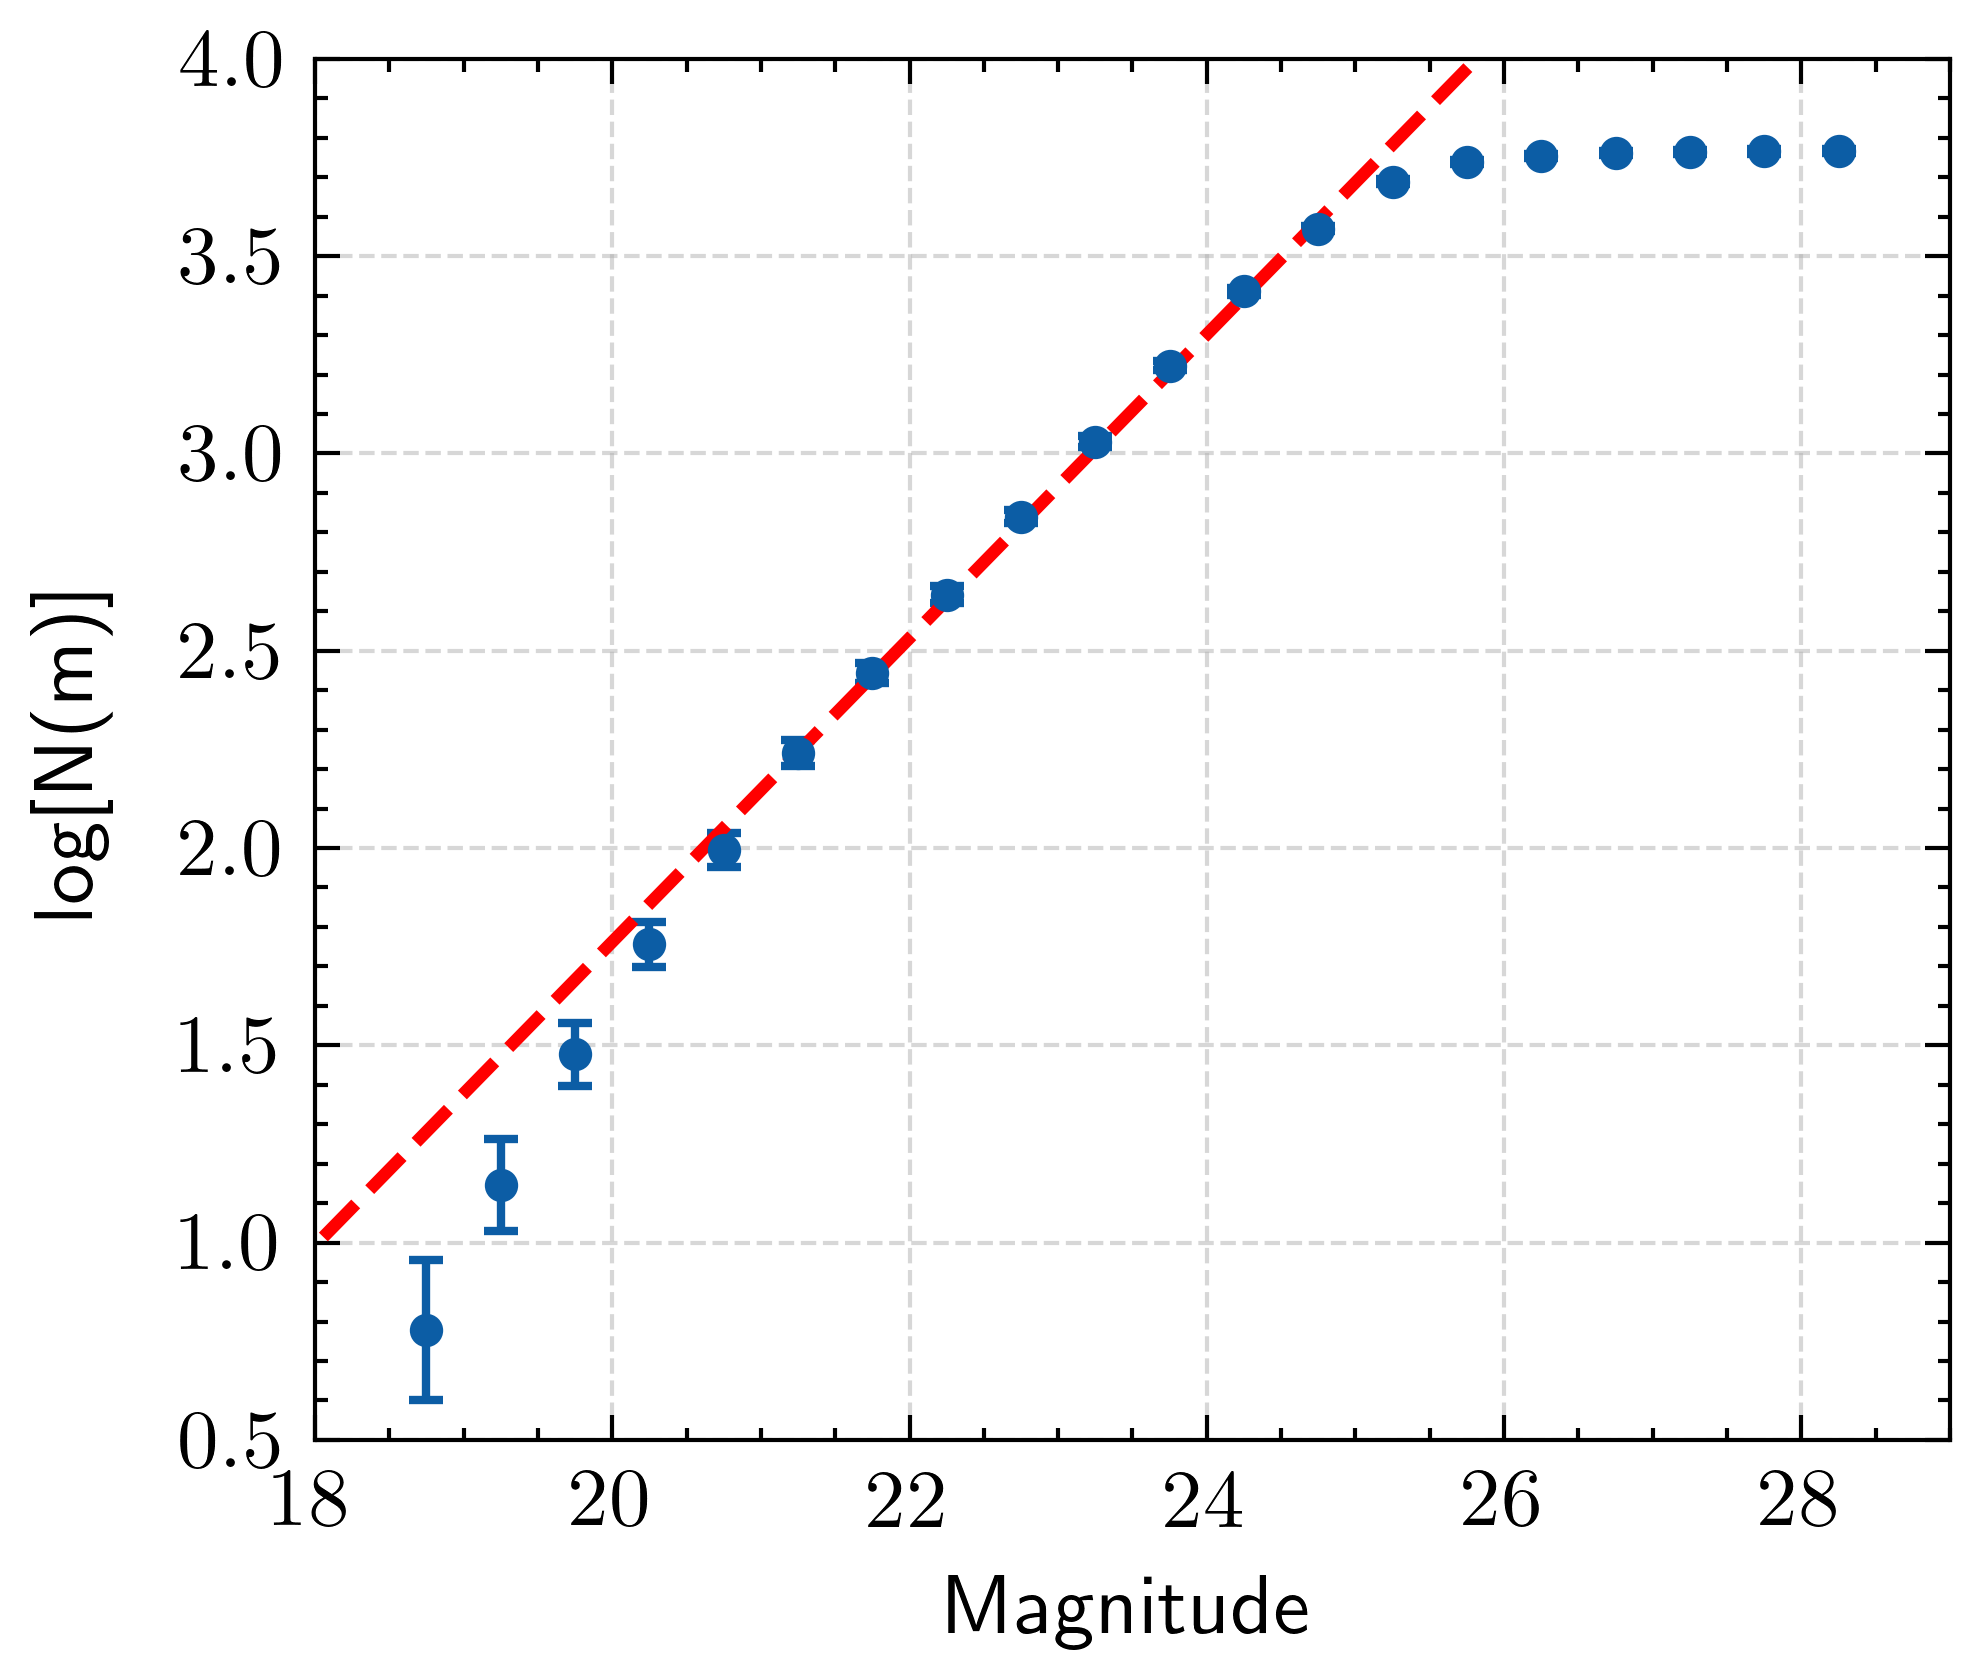

Slope = 0.385 ± 0.004


In [380]:
# remove NaN values first
m_valid = m[~np.isnan(m)]

# make bins, going up by half magnitude (similar to the literature)
bins = np.arange(10, 29, 0.5)
N, edges = np.histogram(m_valid, bins=bins)
cum_N = np.cumsum(N)
m_centers = 0.5 * (edges[1:] + edges[:-1])

# bins with positive cumulative counts
valid = cum_N > 0
x_all = m_centers[valid]
y_all = np.log10(cum_N[valid])
yerr_all = 0.434 * np.sqrt(cum_N[valid]) / cum_N[valid]

# restrict **fit** range only 
fit_mask = (x_all >= 18) & (x_all <= 25)
x_fit_data = x_all[fit_mask]
y_fit_data = y_all[fit_mask]
yerr_fit_data = yerr_all[fit_mask]

# linear model
def linear(m, a, b):
    return a * m + b

popt, pcov = curve_fit(linear, x_fit_data, y_fit_data, sigma=yerr_fit_data, absolute_sigma=True)
slope, intercept = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))

# fit line and 1σ confidence band
x_fit_line = np.linspace(x_fit_data.min()*0.8, x_fit_data.max()*1.2, 200)
y_fit_line = linear(x_fit_line, *popt)
y_upper = linear(x_fit_line, slope + slope_err, intercept + intercept_err)
y_lower = linear(x_fit_line, slope - slope_err, intercept - intercept_err)

# plot everything
plt.figure(figsize=(3.5, 3), dpi=600)
plt.errorbar(x_all, y_all, yerr=yerr_all, fmt='o', ms=3, capsize=2, label='Data')
plt.plot(x_fit_line, y_fit_line, 'r--', lw=1.5, label='Fit')
plt.xlabel('Magnitude')
plt.ylabel(r'log[N(m)]', labelpad=8)
plt.ylim(0.5, 4)
plt.xlim(18, 29)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()
plt.show()

print(f"Slope = {slope:.3f} ± {slope_err:.3f}")


## What does the literature say? 

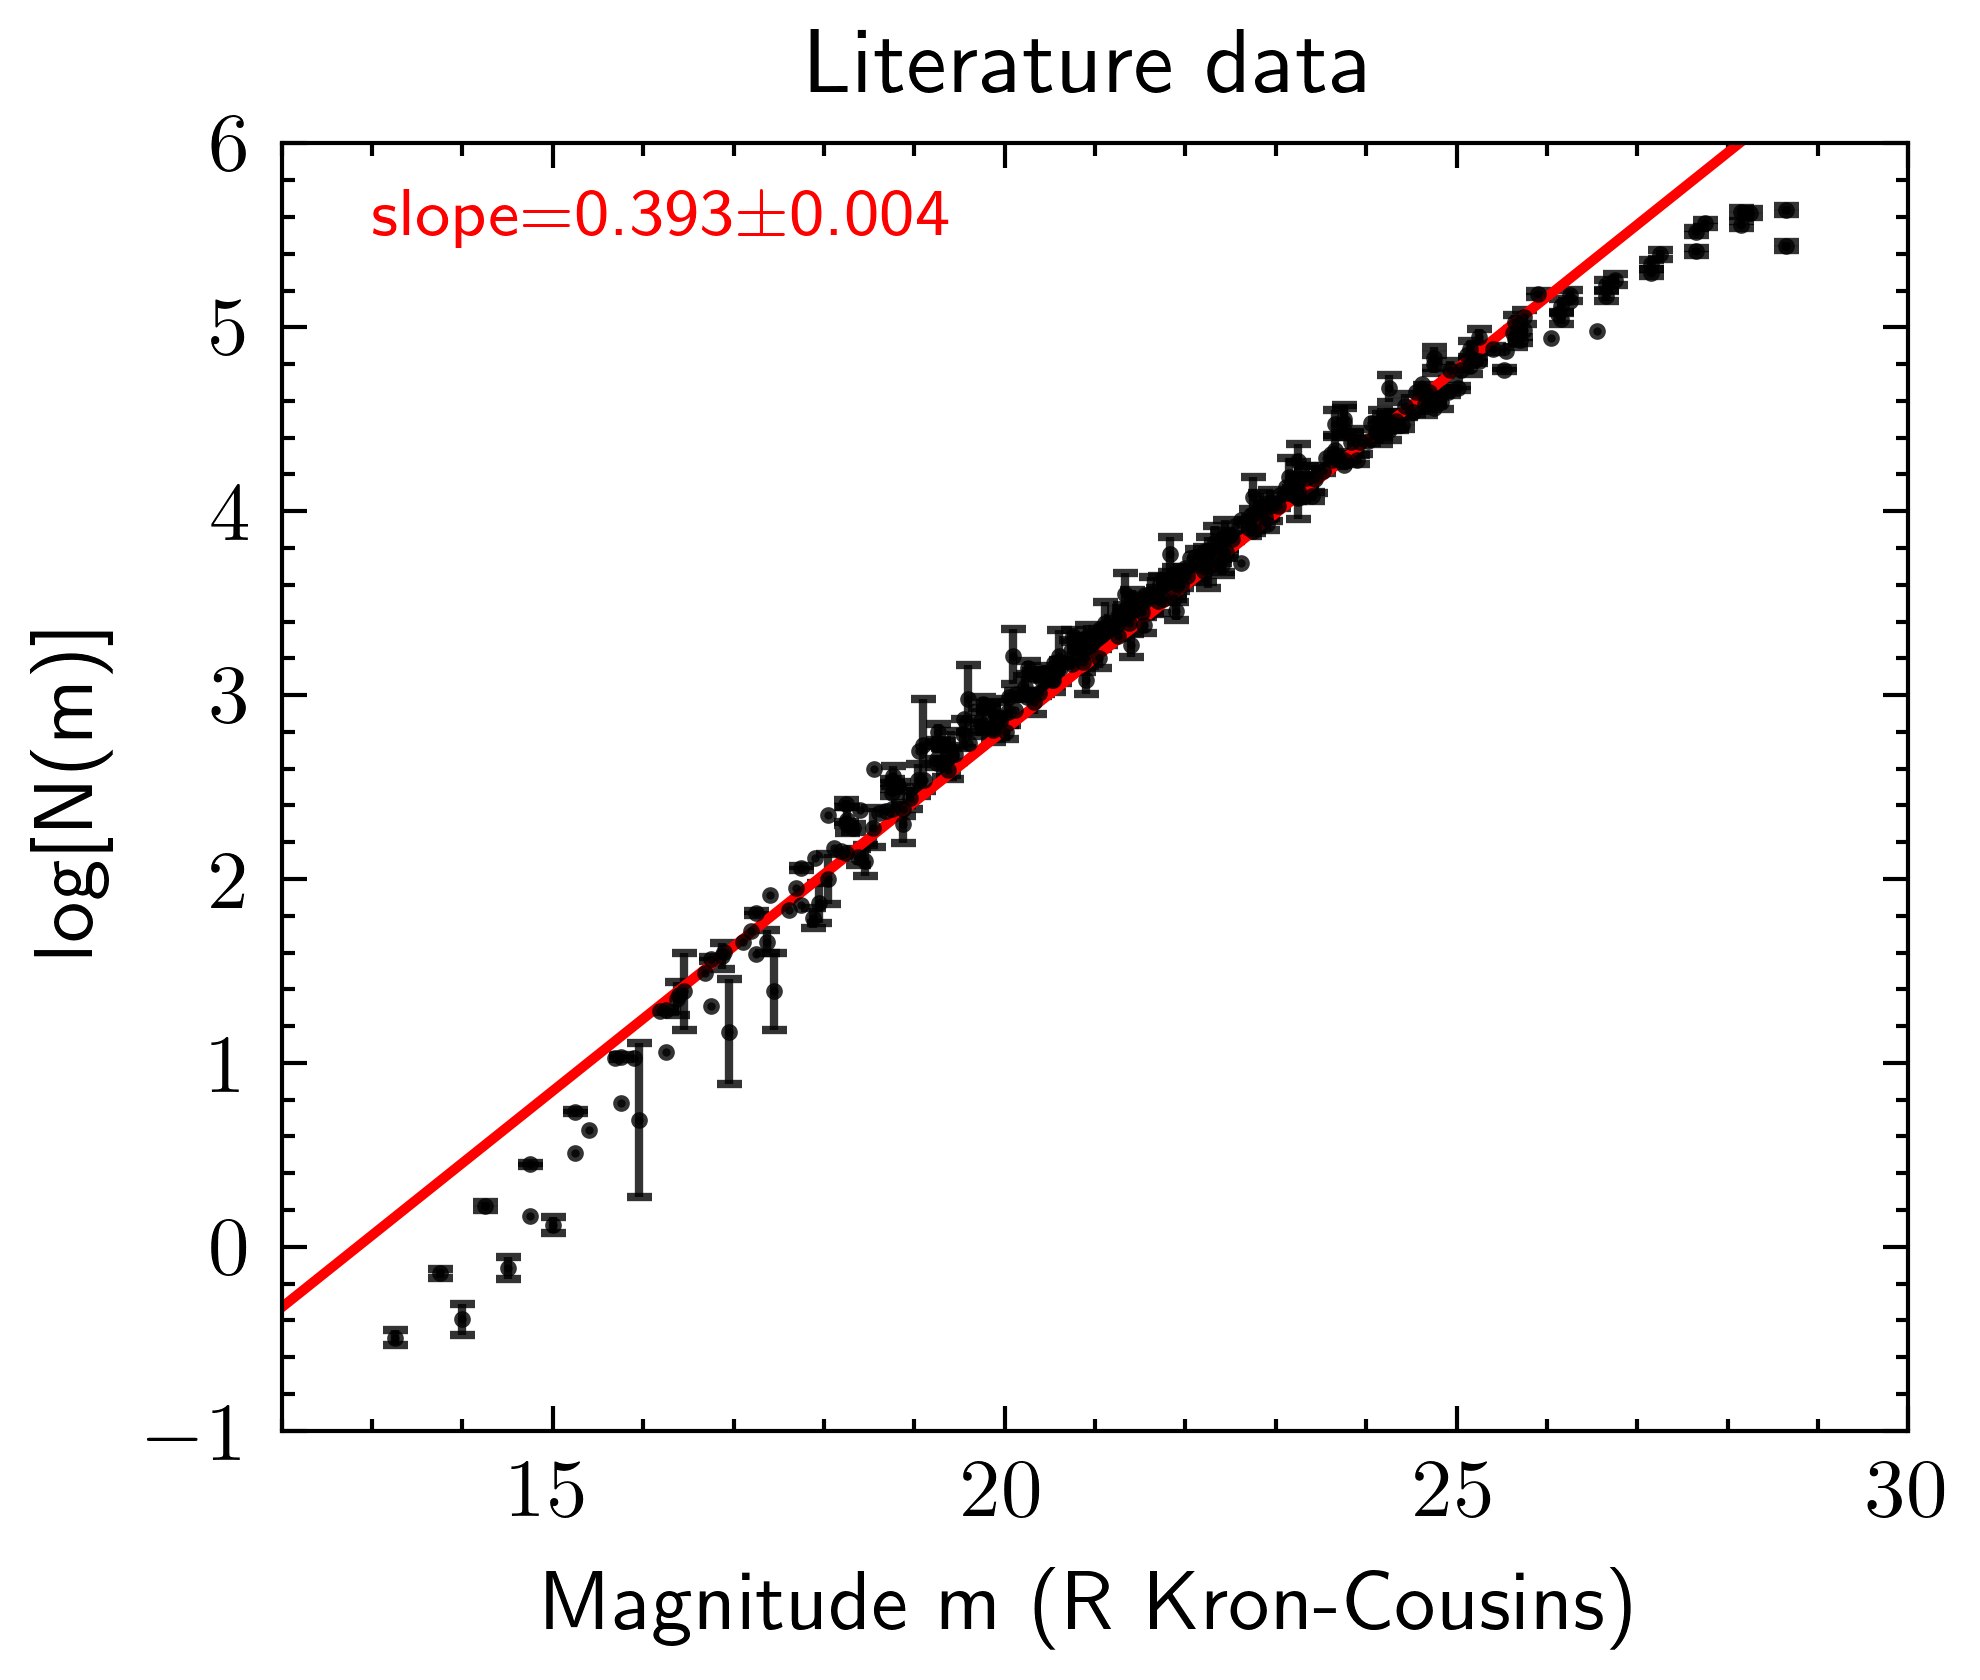

Slope = 0.393 ± 0.004
Intercept = -5.040 ± 0.076


In [369]:
import re
from collections import defaultdict
from itertools import cycle


def plot_Rband(file_path="data/literature/R-band.txt", legend=True):
    data = defaultdict(lambda: {"m": [], "logN": [], "err": [], "years": set()})
    current_label = None

    # --- parse file ---
    with open(file_path, "r") as f:
        for line in f:
            # header (potential legend)
            if re.search(r'[A-Za-z]', line) and not re.match(r'^\s*\d', line):
                label = line.strip().replace('&', r'\&')
                if label:
                    current_label = label
            # numeric data
            elif re.match(r'^\s*-?\d', line) and current_label:
                nums = [float(x) for x in re.findall(r'-?\d+\.?\d*(?:[eE][-+]?\d+)?', line)]
                if len(nums) >= 2:
                    m = nums[0]
                    # 5 cols → average 2nd & 3rd, then 2 errs
                    if len(nums) >= 5:
                        val = 0.5 * (nums[1] + nums[2])
                        err = 0.5 * (nums[3] + nums[4])
                    elif len(nums) == 4:
                        val = nums[1]
                        err = 0.5 * (nums[2] + nums[3])
                    else:
                        val = nums[1]
                        err = np.nan

                    # extract author and year for merging
                    match = re.search(r'([A-Z][a-zA-Z\-]+ et al\.) \((\d{4})\)', current_label)
                    if match:
                        author, year = match.groups()
                        merged_label = author
                        data[merged_label]["years"].add(year)
                    else:
                        merged_label = current_label

                    d = data[merged_label]
                    d["m"].append(m)
                    d["logN"].append(val)
                    d["err"].append(err)

    # --- merge years into labels ---
    merged_data = {}
    for label, d in data.items():
        years = sorted(list(d["years"]))
        year_str = ", ".join(years) if years else ""
        if year_str:
            label_full = f"{label} ({year_str})"
        else:
            label_full = label
        merged_data[label_full] = d

    # --- setup color + marker cycle ---
    colors = plt.cm.tab20(np.linspace(0, 1, 20))
    markers = ["o", "s", "^", "D", "v", "P", "X", ">", "<"]
    color_cyc = cycle(colors)
    marker_cyc = cycle(markers)

    # --- collect all points for fit ---
    all_m, all_logN, all_err = [], [], []

    plt.figure(figsize=(3.5,3), dpi=600)

    if legend:
        for label, d in merged_data.items():
            m = np.array(d["m"])
            logN = np.array(d["logN"])
            err = np.array(d["err"])
            plt.errorbar(m, logN, yerr=err, fmt=next(marker_cyc),
                         ms=2, capsize=2, color=next(color_cyc), label=label)
            all_m.extend(m)
            all_logN.extend(logN)
            all_err.extend(err)
        plt.legend(fontsize=4, ncol = 2, loc='upper left') #ncol=2, bbox_to_anchor=(1.02, 1),
        plt.tight_layout(rect=[0, 0, 0.8, 1])
    else:
        for d in merged_data.values():
            m = np.array(d["m"])
            logN = np.array(d["logN"])
            err = np.array(d["err"])
            plt.errorbar(m, logN, yerr=err, fmt='o', ms=1, color='black', alpha=0.8, capsize=1.5)
            all_m.extend(m)
            all_logN.extend(logN)
            all_err.extend(err)

    # --- fit ---
    all_m = np.array(all_m)
    all_logN = np.array(all_logN)
    all_err = np.array(all_err)
    mask = (all_m >= 12) & (all_m <= 30)
    valid = np.isfinite(all_err) & (all_err > 0)
    sigma = np.where(valid, all_err, np.nanmedian(all_err))

    popt, pcov = curve_fit(linear, all_m[mask], all_logN[mask])
    slope, intercept = popt
    slope_err, intercept_err = np.sqrt(np.diag(pcov))

    # --- fit line ---
    x_line = np.linspace(12, 30, 200)
    plt.plot(x_line, linear(x_line, *popt), 'r-', lw=1.2, label=f"slope={slope:.3f}±{slope_err:.3f}")
    plt.xlabel("Magnitude m (R Kron-Cousins)")
    plt.ylabel(r"log[N(m)]")
    plt.xlim(12, 30)
    plt.ylim(-1, 6)
    plt.title("Literature data", fontsize=11)
    if not legend:
        plt.text(13, 5.5, f"slope={slope:.3f}±{slope_err:.3f}", color='red', fontsize=8)
    plt.tight_layout()
    plt.show()

    print(f"Slope = {slope:.3f} ± {slope_err:.3f}")
    print(f"Intercept = {intercept:.3f} ± {intercept_err:.3f}")

# Example usage:
plot_Rband("data/literature/R-band.txt", legend=False)
# plot_Rband("data/literature/R-band.txt", legend=False)
